# Imports

Here we import different modules etc.. if numba is not present, we fall back to pure numpy execution

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as ax
from numpy import sin, cos, arctan2, sqrt, cross, pi
import scipy.signal
import numpy as geek
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statistics
from scipy.signal import find_peaks_cwt

try:
    from numba import float64, int32
    from numba.experimental import jitclass
except ImportError:
    # Ignore this
    print('Could not import Numba, defaulting to NumPy backend')
    jitclass = lambda spec: lambda f: f
    int32 = float64 = []
    
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

# The IO model

This defines a numba class for optimized execution of the IO model

In [2]:
# Type specification for Numba class compilation
spec = [
    ('ncells', int32),
    ('gj_weight', float64),
    ('rect_param', float64),
    # Parameters
    ('g_int', float64[:]),
    ('p1', float64[:]),
    ('p2', float64[:]),
    ('g_CaL', float64[:]),
    ('g_h', float64[:]),
    ('g_K_Ca', float64[:]),
    ('g_ld', float64[:]),
    ('g_la', float64[:]),
    ('g_ls', float64[:]),
    ('S', float64[:]),
    ('g_Na_s', float64[:]),
    ('g_Kdr_s', float64[:]),
    ('g_K_s', float64[:]),
    ('g_CaH', float64[:]),
    ('g_Na_a', float64[:]),
    ('g_K_a', float64[:]),
    ('V_Na', float64[:]),
    ('V_K', float64[:]),
    ('V_Ca', float64[:]),
    ('V_h', float64[:]),
    ('V_l', float64[:]),
    ('I_app', float64[:]),
    ('I_CaH', float64[:]),
    # Soma state
    ('V_soma', float64[:]),
    ('SOMA_k', float64[:]),
    ('SOMA_l', float64[:]),
    ('SOMA_h', float64[:]),
    ('SOMA_n', float64[:]),
    ('SOMA_x', float64[:]),
    # Axon state
    ('V_axon', float64[:]),
    ('AXON_Sodium_h', float64[:]),
    ('AXON_Potassium_x', float64[:]),
    # Dend state
    ('V_dend', float64[:]),
    ('DEND_Ca2Plus', float64[:]),
    ('DEND_Calcium_r', float64[:]),
    ('DEND_Potassium_s', float64[:]),
    ('DEND_Hcurrent_q', float64[:]),
    # GJ
    ('I_gj', float64[:]),
]


@jitclass(spec)
class IONet:
    '''
    Network of IO <ncells> cells

    When available, optimized using Numba
    Units
     - Voltages in mV
     - Gap junction weight in mS/cm2
    '''

    def __init__(self, ncells):
        self.ncells = ncells
        self.gj_weight = 0.0
        self.rect_param = 8
        # Parameters
        self.g_int = np.full(ncells, 0.13)  # Cell internal conductance  -- now a parameter (0.13)
        self.p1 = np.full(ncells, 0.25)  # Cell surface ratio soma/dendrite
        self.p2 = np.full(ncells, 0.15)  # Cell surface ratio axon(hillock)/soma
        self.g_CaL = np.full(ncells, 1.1)  # Calcium T - (CaV 3.1) (0.7)
        self.g_h = np.full(ncells, 0.12)  # H current (HCN) (0.4996)
        self.g_K_Ca = np.full(ncells, 35.0)  # Potassium  (KCa v1.1 - BK) (35)
        self.g_ld = np.full(ncells, 0.01532)  # Leak dendrite (0.016)
        self.g_la = np.full(ncells, 0.016)  # Leak axon (0.016)
        self.g_ls = np.full(ncells, 0.016)  # Leak soma (0.016)
        self.S = np.full(ncells, 1.0)  # 1/C_m, cm^2/uF
        self.g_Na_s = np.full(ncells, 150.0)  # Sodium  - (Na v1.6 )
        self.g_Kdr_s = np.full(ncells, 9.0)  # Potassium - (K v4.3)
        self.g_K_s = np.full(ncells, 5.0)  # Potassium - (K v3.4)
        self.g_CaH = np.full(ncells, 4.5)  # High-threshold calcium -- Ca V2.1
        self.g_Na_a = np.full(ncells, 240.0)  # Sodium
        self.g_K_a = np.full(ncells, 240.0)  # Potassium (20)
        self.V_Na = np.full(ncells, 55.0)  # Sodium
        self.V_K = np.full(ncells, -75.0)  # Potassium
        self.V_Ca = np.full(ncells, 120.0)  # Low-threshold calcium channel
        self.V_h = np.full(ncells, -43.0)  # H current
        self.V_l = np.full(ncells, 10.0)  # Leak
        self.I_app = np.full(ncells, 0.0)
        self.I_CaH = np.full(ncells, 0.5)
        # Soma state
        self.V_soma = np.full(ncells, -60.0)
        self.SOMA_k = np.full(ncells, 0.7423159)
        self.SOMA_l = np.full(ncells, 0.0321349)
        self.SOMA_h = np.full(ncells, 0.3596066)
        self.SOMA_n = np.full(ncells, 0.2369847)
        self.SOMA_x = np.full(ncells, 0.1)
        # Axon state
        self.V_axon = np.full(ncells, -60.0)
        self.AXON_Sodium_h = np.full(ncells, 0.9)
        self.AXON_Potassium_x = np.full(ncells, 0.2369847)
        # Dend state
        self.V_dend = np.full(ncells, -60.0)
        self.DEND_Ca2Plus = np.full(ncells, 3.715)
        self.DEND_Calcium_r = np.full(ncells, 0.0113)
        self.DEND_Potassium_s = np.full(ncells, 0.0049291)
        self.DEND_Hcurrent_q = np.full(ncells, 0.0337836)
        # GJ
        self.I_gj = np.full(ncells, 0.0)

    def gap_junction_current(self, i, j):
        'Calculate gap junction current acting on cell #i due to cell #j'
        weight = self.gj_weight
        v_i = self.V_dend[i]  # mV
        v_j = self.V_dend[j]  # mV
        vDiff = v_j - v_i
        # print(vDiff,i,j,v_i,v_j)

        Gcx36_inf = 0.2 + 0.8 * np.exp(vDiff * vDiff * (-0.01))

        G_rec_inf = 1.0 / (1 + np.exp((self.V_dend[1] - self.V_dend[0]) / self.rect_param))

        # Without rectification funtion
        # gj_curr = - weight * vDiff * Gcx36_inf

        # with rectification function
        gj_curr = -weight * vDiff * Gcx36_inf * G_rec_inf

        return gj_curr

    def simulate(self, seconds=1, delta=0.025, record_every=40):
        'Simulate and record Vsoma for entire network'
        nepochs = int(seconds * 1000 / delta / record_every + .5)
        out = np.empty((nepochs + 1, self.ncells))
        out[0] = self.V_soma
        for i_epoch in range(nepochs):
            for i_ts in range(record_every):
                self.timestep(delta)
            out[i_epoch + 1] = self.V_soma
        return out

    def timestep(self, delta):
        'Perform a single timestep'
        self.I_gj *= 0
        for i in range(self.ncells):
            for j in range(self.ncells):
                if i == j:
                    continue
                self.I_gj[i] += self.gap_junction_current(i, j)
                # self.I_gj[j] -= self.gap_junction_current(i, j)
        self._update_soma(delta)
        self._update_axon(delta)
        self._update_dend(delta)

    def _update_soma(self, delta):
        'Perform a single soma timestep update'
        # Leak current
        SOMA_I_leak = self.g_ls * (self.V_soma - self.V_l)

        # Interaction Current
        I_ds = (self.g_int / self.p1) * (self.V_soma - self.V_dend)
        I_as = (self.g_int / (1.0 - self.p2)) * (self.V_soma - self.V_axon)
        SOMA_I_interact = I_ds + I_as

        # Channels
        # Low-threshold calcium
        SOMA_Ical = self.g_CaL * self.SOMA_k * self.SOMA_k * self.SOMA_k * self.SOMA_l * (self.V_soma - self.V_Ca)

        SOMA_k_inf = 1.0 / (1.0 + np.exp(-0.23809523809 * self.V_soma - 14.5238))
        SOMA_l_inf = 1.0 / (1.0 + np.exp(0.11764705882 * self.V_soma + 10.0))
        SOMA_tau_l = (20.0 * np.exp(0.033333 * self.V_soma + 5.333333) / (
                    1.0 + np.exp(0.136986 * self.V_soma + 11.506849))) + 35.0

        SOMA_dk_dt = SOMA_k_inf - self.SOMA_k
        SOMA_dl_dt = (SOMA_l_inf - self.SOMA_l) / SOMA_tau_l
        self.SOMA_k = delta * SOMA_dk_dt + self.SOMA_k
        self.SOMA_l = delta * SOMA_dl_dt + self.SOMA_l

        # Sodium   (watch out direct gate m)
        SOMA_m_inf = 1.0 / (1.0 + np.exp(-0.1818181818 * self.V_soma - 5.45454545))
        SOMA_Ina = self.g_Na_s * SOMA_m_inf * SOMA_m_inf * SOMA_m_inf * self.SOMA_h * (self.V_soma - self.V_Na)
        SOMA_tau_h = 3.0 * np.exp(0.0303030303 * self.V_soma + 1.21212121212)
        SOMA_h_inf = 1.0 / (1.0 + np.exp(0.1724137931 * self.V_soma + 12.0689655))
        SOMA_dh_dt = (SOMA_h_inf - self.SOMA_h) * SOMA_tau_h
        self.SOMA_h = self.SOMA_h + delta * SOMA_dh_dt

        # Potassium, slow component
        SOMA_Ikdr = self.g_Kdr_s * self.SOMA_n * self.SOMA_n * self.SOMA_n * self.SOMA_n * (self.V_soma - self.V_K)
        SOMA_n_inf = 1.0 / (1.0 + np.exp(-0.1 * self.V_soma - 0.3))
        SOMA_tau_n = 5.0 + (47.0 * np.exp(0.00111111 * self.V_soma + 0.0555555555))
        SOMA_dn_dt = SOMA_n_inf - self.SOMA_n / SOMA_tau_n
        self.SOMA_n = delta * SOMA_dn_dt + self.SOMA_n

        # Potassium, fast component
        SOMA_Ik = self.g_K_s * self.SOMA_x ** 4 * (self.V_soma - self.V_K)
        SOMA_alpha_x = (0.13 * self.V_soma + 3.25) / (1.0 - np.exp(-0.1 * self.V_soma - 2.5))
        SOMA_beta_x = 1.69 * np.exp(-0.0125 * self.V_soma - 0.4375)
        SOMA_tau_x = SOMA_alpha_x + SOMA_beta_x
        SOMA_x_inf = SOMA_alpha_x / SOMA_tau_x

        SOMA_dx_dt = (SOMA_x_inf - self.SOMA_x) * SOMA_tau_x
        self.SOMA_x = delta * SOMA_dx_dt + self.SOMA_x

        SOMA_I_Channels = SOMA_Ik + SOMA_Ikdr + SOMA_Ina + SOMA_Ical

        # Comp update
        SOMA_dv_dt = self.S * (-(SOMA_I_leak + SOMA_I_interact + SOMA_I_Channels))
        self.V_soma = self.V_soma + SOMA_dv_dt * delta

    def _update_axon(self, delta):
        'Perform a single axon timestep update'
        # Axon hillock components
        # Leak current
        AXON_I_leak = self.g_la * (self.V_axon - self.V_l)

        # Interaction Current
        I_sa = (self.g_int / self.p2) * (self.V_axon - self.V_soma)
        AXON_I_interact = I_sa

        # Channelss
        # Sodium  (watch out direct gate !!!)
        AXON_m_inf = (1.0 / (1.0 + np.exp(-0.18181818 * self.V_axon - 5.45454545)))
        AXON_Ina = self.g_Na_a * AXON_m_inf * AXON_m_inf * AXON_m_inf * self.AXON_Sodium_h * (self.V_axon - self.V_Na)
        AXON_h_inf = (1.0 / (1.0 + np.exp(0.1724137931 * self.V_axon + 10.344827586)))
        AXON_tau_h = 1.5 * np.exp(-0.0303030303 * self.V_axon - 1.212121)
        AXON_dh_dt = ((AXON_h_inf - self.AXON_Sodium_h) / AXON_tau_h)
        self.AXON_Sodium_h = self.AXON_Sodium_h + delta * AXON_dh_dt

        # Potassium
        AXON_Ik = self.g_K_a * (self.AXON_Potassium_x) ** 4 * (self.V_axon - self.V_K)
        AXON_alpha_x = ((0.13 * self.V_axon + 3.25) / (1.0 - np.exp(-0.1 * self.V_axon - 2.5)))
        AXON_beta_x = 1.69 * np.exp(-0.0125 * (self.V_axon + 35.0))
        AXON_x_inf = (AXON_alpha_x / (AXON_alpha_x + AXON_beta_x))
        AXON_tau_x = (1.0 / (AXON_alpha_x + AXON_beta_x))
        AXON_dx_dt = ((AXON_x_inf - self.AXON_Potassium_x) / AXON_tau_x)
        self.AXON_Potassium_x = delta * AXON_dx_dt + self.AXON_Potassium_x

        AXON_I_Channels = AXON_Ina + AXON_Ik

        # comp update
        dv_dt = self.S * (-(AXON_I_leak + AXON_I_interact + AXON_I_Channels))
        self.V_axon = self.V_axon + dv_dt * delta

    def _update_dend(self, delta):
        'Perform a single denrite timestep update'
        # Dendritic Components
        # Application current
        DEND_I_application = self.I_app + self.I_gj

        # Leak current
        DEND_I_leak = self.g_ld * (self.V_dend - self.V_l)

        # Interaction Current
        DEND_I_interact = (self.g_int / (1.0 - self.p1)) * (self.V_dend - self.V_soma)

        # Channels
        # High-threshold calcium
        DEND_Icah = self.g_CaH * self.DEND_Calcium_r * self.DEND_Calcium_r * (self.V_dend - self.V_Ca)
        DEND_alpha_r = (1.7 / (1.0 + np.exp(-0.071942446 * self.V_dend + 0.35971223021)))
        DEND_beta_r = (0.02 * self.V_dend + 0.17) / (np.exp(0.2 * self.V_dend + 1.7) - 1.0)
        DEND_tau_r = (DEND_alpha_r + DEND_beta_r)
        DEND_r_inf = (DEND_alpha_r / DEND_tau_r)
        DEND_dr_dt = (DEND_r_inf - self.DEND_Calcium_r) * DEND_tau_r * 0.2
        self.DEND_Calcium_r = delta * DEND_dr_dt + self.DEND_Calcium_r

        # Calcium dependent potassium
        DEND_Ikca = self.g_K_Ca * self.DEND_Potassium_s * (self.V_dend - self.V_K)
        DEND_alpha_s = (0.00002 * self.DEND_Ca2Plus) * (0.00002 * self.DEND_Ca2Plus < 0.01) + 0.01 * (
                    (0.00002 * self.DEND_Ca2Plus) > 0.01)
        DEND_tau_s = DEND_alpha_s + 0.015
        DEND_s_inf = (DEND_alpha_s / DEND_tau_s)
        DEND_ds_dt = (DEND_s_inf - self.DEND_Potassium_s) * DEND_tau_s
        self.DEND_Potassium_s = delta * DEND_ds_dt + self.DEND_Potassium_s

        # calcium in general
        dCa_dt = -3.0 * DEND_Icah - 0.075 * self.DEND_Ca2Plus
        self.DEND_Ca2Plus = delta * dCa_dt + self.DEND_Ca2Plus

        # h current
        DEND_Ih = self.g_h * self.DEND_Hcurrent_q * (self.V_dend - self.V_h)
        q_inf = 1.0 / (1.0 + np.exp(0.25 * self.V_dend + 20.0))
        tau_q = np.exp(-0.086 * self.V_dend - 14.6) + np.exp(0.070 * self.V_dend - 1.87)
        dq_dt = (q_inf - self.DEND_Hcurrent_q) * tau_q
        self.DEND_Hcurrent_q = delta * dq_dt + self.DEND_Hcurrent_q

        DEND_I_Channels = DEND_Icah + DEND_Ikca + DEND_Ih

        # comp update
        DEND_dv_dt = self.S * (-(DEND_I_leak + DEND_I_interact + DEND_I_application + DEND_I_Channels))
        self.V_dend = self.V_dend + DEND_dv_dt * delta

# Helper functions

In [3]:
def gj_weight_comparison():
    n = IONet(10)
    n.g_CaL *= 2 * np.random.random(n.ncells)

    n.gj_weight = 0.0
    b = time.time()
    Vsoma1 = n.simulate(1)
    e = time.time()
    # print(e - b)

    n.gj_weight = 0.05
    b = time.time()
    Vsoma2 = n.simulate(1)
    e = time.time()
    # print(e - b)

    # Plot results
    fig, ax = plt.subplots(nrows=2, sharex=True)
    ax[0].set_ylabel('Vsoma (mV)')
    ax[1].set_ylabel('Vsoma (mV)')
    ax[1].set_xlabel('Time (ms)')
    ax[0].set_title('Gap junction weight = 0')
    ax[0].plot(Vsoma1, color='black', alpha=0.5)
    ax[1].set_title(f'Gap junction weight = {n.gj_weight}')
    ax[1].plot(Vsoma2 + Vsoma1.std() * 4, color='black', alpha=0.5)
    plt.show()


def drive_response() -> object:
    n = IONet(2)  # 2 neurons
    n.g_CaL[1] *= 0.5  # make neuron #2 a damped oscillator
    n.V_Ca[1] *= 1.1

    # Warm up JIT cache / discard transients
    b = time.time()
    _discard = n.simulate(.5)
    e = time.time()
    # print(f'Transient simulation time: {e-b:.2f}s')

    # Simulate without driving
    n.gj_weight = 0.0
    b = time.time()
    Vsoma1 = n.simulate(1)
    e = time.time()
    # print(e - b)
    # print(f'Simulation time: {e-b:.2f}s')

    # Create gap junction connections
    n.gj_weight = 0.05

    # Discard transients
    b = time.time()
    _discard = n.simulate(.5)
    e = time.time()
    # print(f'Transient simulation time: {e-b:.2f}s')

    # Simulate with driving
    b = time.time()
    Vsoma2 = n.simulate(1)
    e = time.time()
    # print(e - b)
    # print(f'Simulation time: {e-b:.2f}s')

    fig, ax = plt.subplots(nrows=2, sharex=True)
    ax[0].set_ylabel('Vsoma (mV)')
    ax[1].set_ylabel('Vsoma (mV)')
    ax[1].set_xlabel('Time (ms)')
    ax[0].set_title('Gap junction weight = 0')
    ax[0].plot(Vsoma1[:, 0], color='black')
    ax[0].plot(Vsoma1[:, 1], color='red')
    ax[1].set_title(f'Gap junction weight = {n.gj_weight}')
    ax[1].plot(Vsoma2[:, 0] + Vsoma1.std() * 4, color='black')
    ax[1].plot(Vsoma2[:, 1] + Vsoma1.std() * 4, color='red')
    plt.show()


def drive_response1():
    o = IONet(2)
    o.g_K_Ca[1] = 38

    Vsoma1_new = o.simulate(1)
    o.gj_weight = 0.05
    Vsoma2_new = o.simulate(1)

    plt.figure(1)
    plt.ylabel('Vsoma (mV)')
    plt.xlabel('Time (ms)')
    plt.title(f'Gap junction weight = {o.gj_weight}')
    plt.plot(Vsoma2_new[:, 0] + Vsoma1_new.std() * 4, color='black')
    plt.plot(Vsoma2_new[:, 1] + Vsoma1_new.std() * 4, color='red')
    plt.show()


def phase_shift():
    x = np.linspace(0, 20, 100)
    y = sin(x)
    peaks, props = scipy.signal.find_peaks(y)
    print(peaks)
    ax.axvline(8, color='orange')
    ax.axvline(39, color='orange')
    ax.axvline(70, color='orange')
    plt.plot(y)
    plt.show()

# Plot


Use this code to generate the normal plot

Change the references to K_s to a different channel for the other plots

100%|██████████████████████████████████████████████████████████| 21/21 [00:56<00:00,  2.69s/it]


''

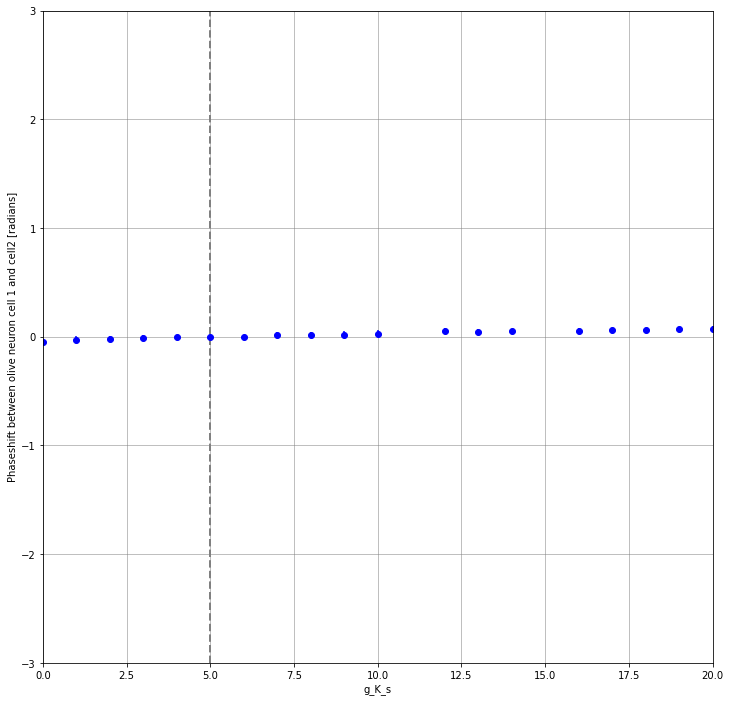

In [4]:
# you can change the range for specific voltage gated channel
x=np.linspace(0,20,21)

een_array = []
een_array1 = []
een_array2 = []
een_array3 = []
een_array4 = []
een_array5 = []
een_array6 = []
een_array7 = []
een_array8 = []
een_array9 = []
een_array10 = []

een_array12 = []
een_array13 = []

een_array31 = []
een_array41 = []
een_array61 = []
een_array81 = []
een_array11 = []
een_array71 = []
een_array101 = []
een_array91 = []

kk = 4

for e in tqdm(x):
    n = IONet(2)

    n.gj_weight = 0.05
    #investigated conductivity parameter, you can change them into other parameters g_Na_a, g_Na_s etc. 
    n.g_K_s[1] = e
    een_array.append(n.g_K_s[1])

    Vsoma1 = n.simulate(kk)
    Vsoma2 = n.simulate(kk)

    maximum = max(Vsoma2[:, 1])
    minimum = min(Vsoma2[:, 1])

    amplitude = abs(minimum - maximum) / 2

    peaks2, props = scipy.signal.find_peaks(Vsoma2[:, 1])
    peaks1, props = scipy.signal.find_peaks(Vsoma2[:, 0])

    if peaks2.size > 0:
        peaks2 = peaks2[peaks2 > peaks1.min()]
        peaks1 = peaks1[peaks1 < peaks2.max()]

        if amplitude < 1 and len(peaks1) == len(peaks2):
            een_array12.append(e)

            new_peaks2 = peaks2
            aantal_counts = len(new_peaks2)
            een_array3.append(new_peaks2)
            new_peaks1 = peaks1
            een_array4.append(new_peaks1)

            data = np.linspace(0, aantal_counts, aantal_counts + 1)
            data = np.array(data, dtype=np.int32)

            start = aantal_counts - 1
            for i in data:
                if i < start:
                    difference_peak = new_peaks1[i + 1] - new_peaks1[i]
                    delta_time = new_peaks2[i] - new_peaks1[i]
                    een_array6.append(difference_peak)
                    een_array8.append(delta_time)

            # standaard deviation
            #print(een_array8)
            uitkomst = np.multiply(np.divide(een_array8, een_array6), (math.pi) * (2))
            #print(uitkomst)

            std = statistics.stdev(uitkomst)
            een_array1.append(std)

            summation = sum(een_array6)
            summation1 = sum(een_array8)

            lenght_array = len(een_array6)
            lenght_array1 = len(een_array8)
            average = summation / lenght_array

            average1 = summation1 / lenght_array1

            een_array7.append(average)
            een_array10.append(average1)
            solution = (average1 / average) * (math.pi) * 2
            print(solution)
            een_array9.append(solution)

            een_array6.clear()
            een_array8.clear()



        elif len(peaks1) == len(peaks2):

            een_array13.append(e)

            new_peaks21 = peaks2
            aantal_counts1 = len(new_peaks21)
            een_array31.append(new_peaks21)
            new_peaks11 = peaks1
            een_array41.append(new_peaks11)

            data1 = np.linspace(0, aantal_counts1, aantal_counts1 + 1)
            data1 = np.array(data1, dtype=np.int32)

            start = aantal_counts1 - 1
            for i in data1:
                if i < start:
                    difference_peak1 = new_peaks11[i + 1] - new_peaks11[i]

                    delta_time1 = new_peaks21[i] - new_peaks11[i]
                    een_array61.append(difference_peak1)
                    een_array81.append(delta_time1)

            # standaard deviation
            #print(een_array61)
            #print(een_array81)
            uitkomst1 = np.multiply(np.divide(een_array81, een_array61), (math.pi) * (2))

            #print(uitkomst1)

            std1 = statistics.stdev(uitkomst1)
            een_array11.append(std1)

            summation1 = sum(een_array61)
            summation11 = sum(een_array81)

            lenght_array1 = len(een_array61)
            lenght_array11 = len(een_array81)
            average1 = summation1 / lenght_array1

            average11 = summation11 / lenght_array11

            een_array71.append(average1)
            een_array101.append(average11)
            solution1 = (average11 / average1) * (math.pi) * 2
            #print(solution1)
            een_array91.append(solution1)

            een_array61.clear()
            een_array81.clear()

een_array9 = np.array(een_array9)
een_array91 = np.array(een_array91)

y = (een_array9 + np.pi) % (2. * np.pi) - np.pi
y1 = (een_array91 + np.pi) % (2. * np.pi) - np.pi

yerror = een_array1
yerror1 = een_array11

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(111)
plt.errorbar(een_array12, y, yerr=yerror, fmt='^', color='green')
plt.errorbar(een_array13, y1, yerr=yerror1, fmt='o', color='blue')
plt.axvline(x=5, linestyle='--', color='grey', linewidth=2)
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.ylabel('Phaseshift between olive neuron cell 1 and cell2 [radians]')
plt.xlabel('g_K_s')
plt.ylim((-3,3))
plt.xlim((0,20))
;

# Detail plot

Use this code to generate the detail plot with STO insets

  1%|▌                                                         | 1/101 [00:01<02:45,  1.65s/it]

0.746229206148321


  2%|█▏                                                        | 2/101 [00:03<02:37,  1.59s/it]

0.7963008628379269


  4%|██▎                                                       | 4/101 [00:06<02:28,  1.53s/it]

0.8523951290315575
0.9386072507131723


  5%|██▊                                                       | 5/101 [00:07<02:26,  1.52s/it]

1.0836964919866379


  6%|███▍                                                      | 6/101 [00:09<02:24,  1.52s/it]

1.338828959169079


  7%|████                                                      | 7/101 [00:10<02:22,  1.52s/it]

1.8151068212734502


 10%|█████▋                                                   | 10/101 [00:15<02:14,  1.47s/it]

1.059165523210273


 11%|██████▏                                                  | 11/101 [00:16<02:10,  1.45s/it]

0.4795104533589102


 12%|██████▊                                                  | 12/101 [00:18<02:12,  1.48s/it]

6.283185307179586


 14%|███████▉                                                 | 14/101 [00:21<02:12,  1.52s/it]

5.845236948577305
5.3202697908311585


100%|████████████████████████████████████████████████████████| 101/101 [02:40<00:00,  1.59s/it]


[0.74622921 0.79630086 0.85239513]
[0.74622921 0.79630086 0.85239513]
[ 0.93860725  1.08369649  1.33882896  1.81510682  1.05916552  0.47951045
  0.         -0.43794836 -0.96291552]


''

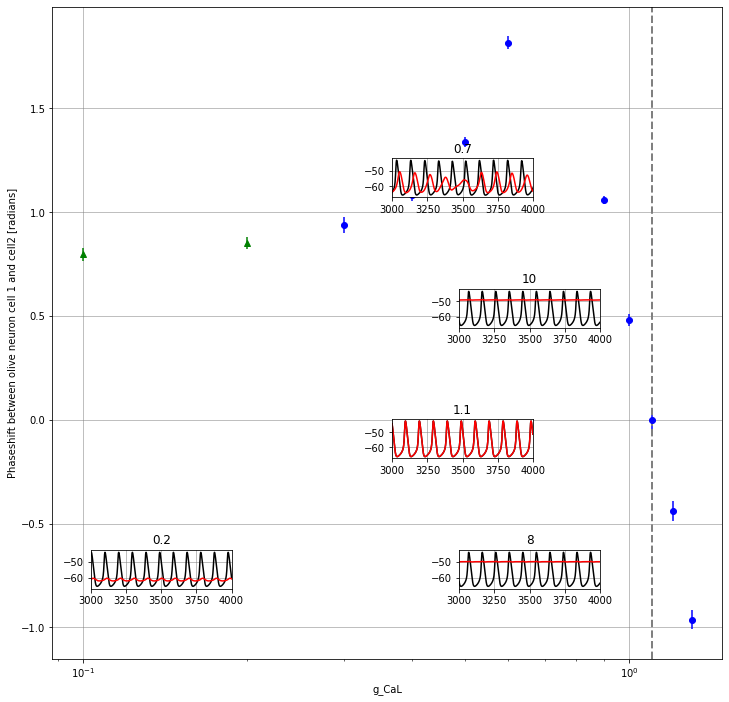

In [5]:
x = np.linspace(0, 10, 101)

een_array = []
een_array1 = []
een_array2 = []
een_array3 = []
een_array4 = []
een_array5 = []
een_array6 = []
een_array7 = []
een_array8 = []
een_array9 = []
een_array10 = []

een_array12 = []
een_array13 = []

een_array31 = []
een_array41 = []
een_array61 = []
een_array81 = []
een_array11 = []
een_array71 = []
een_array101 = []
een_array91 = []

kk = 4

for e in tqdm(x):
    n = IONet(2)
    n.gj_weight = 0.05

    n.g_CaL[1] = e
    een_array.append(n.g_CaL[1])

    Vsoma1 = n.simulate(kk)
    Vsoma2 = n.simulate(kk)

    maximum = max(Vsoma2[:, 1])
    minimum = min(Vsoma2[:, 1])

    amplitude = abs(minimum - maximum) / 2

    peaks2, props = scipy.signal.find_peaks(Vsoma2[:, 1])
    peaks1, props = scipy.signal.find_peaks(Vsoma2[:, 0])

    if peaks2.size > 0:
        peaks2 = peaks2[peaks2 > peaks1.min()]
        peaks1 = peaks1[peaks1 < peaks2.max()]

        if amplitude < 1 and len(peaks1) == len(peaks2):
            een_array12.append(e)

            new_peaks2 = peaks2
            aantal_counts = len(new_peaks2)
            een_array3.append(new_peaks2)
            new_peaks1 = peaks1
            een_array4.append(new_peaks1)

            data = np.linspace(0, aantal_counts, aantal_counts + 1)
            data = np.array(data, dtype=np.int32)

            start = aantal_counts - 1
            for i in data:
                if i < start:
                    difference_peak = new_peaks2[i + 1] - new_peaks2[i]
                    delta_time = new_peaks2[i] - new_peaks1[i]
                    een_array6.append(difference_peak)
                    een_array8.append(delta_time)

            # standaard deviation
            uitkomst = np.multiply(np.divide(een_array8, een_array6), (math.pi) * (2))

            std = statistics.stdev(uitkomst)
            een_array1.append(std)

            summation = sum(een_array6)
            summation1 = sum(een_array8)

            lenght_array = len(een_array6)
            lenght_array1 = len(een_array8)
            average = summation / lenght_array

            average1 = summation1 / lenght_array1

            een_array7.append(average)
            een_array10.append(average1)
            solution = (average1 / average) * (math.pi) * 2
            print(solution)
            een_array9.append(solution)

            een_array6.clear()
            een_array8.clear()



        elif len(peaks1) == len(peaks2):

            een_array13.append(e)

            new_peaks21 = peaks2
            aantal_counts1 = len(new_peaks21)
            een_array31.append(new_peaks21)
            new_peaks11 = peaks1
            een_array41.append(new_peaks11)

            data1 = np.linspace(0, aantal_counts1, aantal_counts1 + 1)
            data1 = np.array(data1, dtype=np.int32)

            start = aantal_counts1 - 1
            for i in data1:
                if i < start:
                    difference_peak1 = new_peaks21[i + 1] - new_peaks21[i]
                    delta_time1 = new_peaks21[i] - new_peaks11[i]
                    een_array61.append(difference_peak1)
                    een_array81.append(delta_time1)

            # standaard deviation
            uitkomst1 = np.multiply(np.divide(een_array81, een_array61), (math.pi) * (2))

            std1 = statistics.stdev(uitkomst1)
            een_array11.append(std1)

            summation1 = sum(een_array61)
            summation11 = sum(een_array81)

            lenght_array1 = len(een_array61)
            lenght_array11 = len(een_array81)
            average1 = summation1 / lenght_array1

            average11 = summation11 / lenght_array11

            een_array71.append(average1)
            een_array101.append(average11)
            solution1 = (average11 / average1) * (math.pi) * 2
            print(solution1)
            een_array91.append(solution1)

            een_array61.clear()
            een_array81.clear()

een_array9 = np.array(een_array9)
een_array91 = np.array(een_array91)

print(een_array9)

y = (een_array9 + np.pi) % (2. * np.pi) - np.pi
y1 = (een_array91 + np.pi) % (2. * np.pi) - np.pi

yerror = een_array1
yerror1 = een_array11

print(y)
print(y1)

# calculation small plots

f1 = IONet(2)
f1.g_CaL[1] = 0.2

Vsoma1_new1 = f1.simulate(kk)
f1.gj_weight = 0.05
Vsoma2_new1 = f1.simulate(kk)

f2 = IONet(2)
f2.g_CaL[1] = 0.7

Vsoma1_new2 = f2.simulate(kk)
f2.gj_weight = 0.05
Vsoma2_new2 = f2.simulate(kk)

f3 = IONet(2)
f3.g_CaL[1] = 1.1

Vsoma1_new3 = f1.simulate(kk)
f3.gj_weight = 0.05
Vsoma2_new3 = f3.simulate(kk)

f4 = IONet(2)
f4.g_CaL[1] = 8

Vsoma1_new4 = f4.simulate(kk)
f4.gj_weight = 0.05
Vsoma2_new4 = f4.simulate(kk)

f5 = IONet(2)
f5.g_CaL[1] = 10

Vsoma1_new5 = f5.simulate(kk)
f5.gj_weight = 0.05
Vsoma2_new5 = f5.simulate(kk)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(111)
plt.errorbar(een_array12, y, yerr=yerror, fmt='^', color='green')
plt.errorbar(een_array13, y1, yerr=yerror1, fmt='o', color='blue')
plt.xscale('log')
plt.axvline(x=1.1, linestyle='--', color='grey', linewidth=2)
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.ylabel('Phaseshift between olive neuron cell 1 and cell2 [radians]')
plt.xlabel('g_CaL')


axins = inset_axes(ax, width="35%", height="15%",
                   bbox_to_anchor=(0.05, .1, .6, .4),
                   bbox_transform=ax.transAxes, loc=3)
plt.plot(Vsoma2_new1[:, 0], color='black')
plt.plot(Vsoma2_new1[:, 1], color='red')
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.xlim(right=4000)
plt.xlim(left=3000)
plt.title('0.2')

axins = inset_axes(ax, width="35%", height="15%",
                   bbox_to_anchor=(.5, .7, .6, .4),
                   bbox_transform=ax.transAxes, loc=3)
plt.plot(Vsoma2_new2[:, 0], color='black')
plt.plot(Vsoma2_new2[:, 1], color='red')
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.xlim(right=4000)
plt.xlim(left=3000)
plt.title('0.7')

axins = inset_axes(ax, width="35%", height="15%",
                   bbox_to_anchor=(.5, .3, .6, .4),
                   bbox_transform=ax.transAxes, loc=3)
plt.plot(Vsoma2_new3[:, 0], color='black')
plt.plot(Vsoma2_new3[:, 1], color='red')
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.xlim(right=4000)
plt.xlim(left=3000)
plt.title('1.1')

axins = inset_axes(ax, width="35%", height="15%",
                   bbox_to_anchor=(.6, .1, .6, .4),
                   bbox_transform=ax.transAxes, loc=3)
plt.plot(Vsoma2_new4[:, 0], color='black')
plt.plot(Vsoma2_new4[:, 1], color='red')
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.xlim(right=4000)
plt.xlim(left=3000)
plt.title('8')

axins = inset_axes(ax, width="35%", height="15%",
                   bbox_to_anchor=(.6, .5, .6, .4),
                   bbox_transform=ax.transAxes, loc=3)
plt.plot(Vsoma2_new5[:, 0], color='black')
plt.plot(Vsoma2_new5[:, 1], color='red')
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.xlim(right=4000)
plt.xlim(left=3000)
plt.title('10')



;